# Imports

In [1]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from scipy.stats import weibull_min, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import uuid
import kaleido
import plotly.express as px
import model_functions as func
import math
import random
import tqdm
import plotly.graph_objects as go

# Befolkningsmodel

In [2]:
# Indlæs befolkningsdata 1950-2023, alle lande, 1-års intervaller
befolkning = pd.read_excel("./populationsdata/WPP2024_POP_F01_1_POPULATION_SINGLE_AGE_BOTH_SEXES.xlsx", header=16)
befolkning = befolkning.loc[befolkning.Type == "Country/Area"].reset_index()
iso_to_reg = pd.read_csv("./populationsdata/iso_to_region.csv")
befolkning = befolkning.merge(
    iso_to_reg[['alpha-3', 'region']], 
    left_on='ISO3 Alpha-code',
    right_on='alpha-3',
    how='left'
)

# Check the number of countries and years
print(f"Number of countries: {befolkning['ISO3 Alpha-code'].nunique()}")
print(f"Number of years: {befolkning['Year'].nunique()}")

# Additional checks
print(f"Number of rows: {befolkning.shape[0]}")
print(f"Number of columns: {befolkning.shape[1]}")

# indlæs HDI data 1990 - 2023 
hdi = pd.read_csv("./populationsdata/HDR23-24_Composite_indices_complete_time_series.csv", encoding='latin1')

Number of countries: 237
Number of years: 74
Number of rows: 17538
Number of columns: 115


In [3]:
# First, let's prepare the future data
befolkning_frem = pd.read_csv("./populationsdata/WPP2024_Demographic_Indicators_Medium.csv")
befolkning_frem = befolkning_frem[["ISO3_code","ISO2_code","Time","Births"]]
befolkning_frem = befolkning_frem.loc[befolkning_frem.Time>2023]
befolkning_frem = befolkning_frem.rename(columns={
    'ISO3_code': 'ISO3 Alpha-code',
    'ISO2_code': 'ISO2 Alpha-code', 
    'Time': 'Year',
    'Births':0
})
# Append future population data to befolkning
befolkning = pd.concat([befolkning, befolkning_frem], ignore_index=True)

# Sort by country and year to ensure chronological order
befolkning = befolkning.sort_values(['ISO3 Alpha-code', 'Year'])
static_columns = ['Variant', 'Region, subregion, country or area *', 'Notes', 
                 'Location code', 'SDMX code**', 'Type', 'region']
befolkning[static_columns] = befolkning.groupby('ISO3 Alpha-code')[static_columns].ffill()


# Print verification of the merge
print(f"Data now spans years: {befolkning['Year'].min()} - {befolkning['Year'].max()}")
print(f"Number of countries: {befolkning['ISO3 Alpha-code'].nunique()}")

/Users/smeden/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data now spans years: 1950.0 - 2101.0
Number of countries: 237


In [4]:
# Get list of HDI columns for years 1990-2023
hdi_cols = [f'hdi_{year}' for year in range(1990, 2023)]

# Select iso3 column and all HDI columns
hdi = hdi[['iso3'] + hdi_cols]

# Merge HDI data with population data
befolkning = befolkning.merge(hdi, left_on='ISO3 Alpha-code', right_on='iso3', how='left')


# Then adjust the HDI columns list based on actual column names
# For example, if the columns are named like 'HDI_1990' instead of 'hdi_1990':
hdi_cols = [col for col in hdi.columns if col.startswith('HDI_') or col.startswith('hdi_')]

# Now proceed with the merging and filling
for col in hdi_cols:
    # Calculate regional means for current HDI year, excluding NaN values
    regional_means = befolkning.groupby('region')[col].mean()
    
    # For each region, fill NaN values with that region's mean
    for region in befolkning['region'].dropna().unique():
        region_mask = befolkning['region'] == region
        region_mean = regional_means[region]
        befolkning.loc[region_mask, col] = befolkning.loc[region_mask, col].fillna(region_mean)

In [5]:

# ---------------------------------------------------------------------
# 1) HDI retrieval with interpolation
# ---------------------------------------------------------------------
def get_effective_hdi(row,
                     year_col='Year',
                     hdi_floor=0.15,
                     pre_discovery_year=1956,
                     reference_year=1992,
                     final_year=2022,
                     growth_rates=None):
    """
    Returns an HDI for row[year_col] with updated rules:
      1) If year < pre_discovery_year => minimal detection => returns 0
      2) If pre_discovery_year <= year < reference_year => linear interpolation
      3) If 1990 <= year <= 2022 => use historical data
      4) If year > 2022 => project forward using country-specific growth rate
    """
    year = int(row[year_col])
    
    # Case 1: Before discovery
    if year < pre_discovery_year:
        return 0.0
        
    # Case 2: Between discovery and reference year
    if pre_discovery_year <= year < reference_year:
        total_years = reference_year - pre_discovery_year
        years_from_discovery = year - pre_discovery_year
        # Linear interpolation from hdi_floor to first available HDI
        first_hdi = row.get('hdi_1990', 0.5)  # fallback to 0.5 if missing
        return hdi_floor + (first_hdi - hdi_floor) * (years_from_discovery / total_years)
    
    # Case 3: Historical HDI data (1990-2022)
    if 1990 <= year <= final_year:
        hdi_col = f'hdi_{year}'
        return row.get(hdi_col, 0.5)  # fallback to 0.5 if missing
    
    # Case 4: Future projections
    if year > final_year:
        # Get base HDI value from 2022
        base_hdi = row.get('hdi_2022', 0.5)  # fallback to 0.5 if missing
        
        # Get country-specific growth rate (or default to global average)
        country_code = row['ISO3 Alpha-code']
        growth_rate = growth_rates.get(country_code, 0.005)  # default 0.5% annual growth
        
        # Calculate projected HDI
        years_forward = year - final_year
        projected_hdi = base_hdi * (1 + growth_rate) ** years_forward
        
        # Cap at 1.0 and floor at hdi_floor
        return min(1.0, max(hdi_floor, projected_hdi))

def calculate_hdi_growth_rates(df):
    """
    Calculate average annual HDI growth rates for each country from 1990-2022.
    Returns a dictionary of {country_code: growth_rate}.
    """
    growth_rates = {}
    
    for _, row in df.drop_duplicates('ISO3 Alpha-code').iterrows():
        country = row['ISO3 Alpha-code']
        
        # Get 1990 and 2022 HDI values
        hdi_1990 = row.get('hdi_1990')
        hdi_2022 = row.get('hdi_2022')
        
        if pd.notna(hdi_1990) and pd.notna(hdi_2022) and hdi_1990 > 0:
            # Calculate compound annual growth rate
            years = 2022 - 1990
            growth_rate = (hdi_2022 / hdi_1990) ** (1/years) - 1
            growth_rates[country] = growth_rate
        else:
            # Use global average or default if missing data
            growth_rates[country] = 0.005  # 0.5% default growth
    
    return growth_rates

# Calculate growth rates
hdi_growth_rates = calculate_hdi_growth_rates(befolkning)

# Apply the function to get projected HDI values
befolkning['projected_hdi'] = befolkning.apply(
    lambda row: get_effective_hdi(
        row, 
        growth_rates=hdi_growth_rates
    ), 
    axis=1
)

In [6]:

# ---------------------------------------------------------------------
# 2) Zero-inflated Poisson for new (age-0) cases
# ---------------------------------------------------------------------
def simulate_cases_for_row(row,
                           incidence_rate=1/20000,
                           disease_discovery_year=1956,
                           year_col='Year',
                           pop_col=0):
    """
    Row-level ZIP logic:
      - If year < discovery => 0
      - Else HDI = get_effective_hdi(...)
        zero_infl_prob = 1 - HDI
        structural zero => random check
        else Poisson( pop_age0 * incidence_rate * (1 + HDI) )
    Note: pop_col references the column with newborn population (set to '0' by default).
          multiply by 1000 if needed, etc.
    """

    year = int(row[year_col])
    # Example: treat the 'pop_col' column as *thousands* => multiply by 1000
    pop_age0 = row.get(pop_col, 0) * 1000  
    if pd.isna(pop_age0) or pop_age0 <= 0:
        return 0

    # If year < disease_discovery_year => 0
    if year < disease_discovery_year:
        return 0

    # get HDI
    hdi_current = row['projected_hdi']

    # zero-inflation
    zero_infl_prob = 1.0 - hdi_current
    zero_infl_prob = max(0.0, min(1.0, zero_infl_prob))

    # structural zero check
    if np.random.random() < zero_infl_prob:
        return 0

    # Poisson mean
    lam = pop_age0 * incidence_rate * (1.0 + hdi_current)
    return np.random.poisson(lam)


def simulate_cases_for_dataframe(befolkning,
                                 incidence_rate=1/100000,
                                 disease_discovery_year=1956,
                                 year_col='Year',
                                 pop_col=0):
    """
    Applies simulate_cases_for_row to each row of 'befolkning',
    storing the result in 'simulated_cases'.
    """
    df = befolkning.copy()
    df['simulated_cases'] = df.apply(
        simulate_cases_for_row,
        axis=1,
        incidence_rate=incidence_rate,
        disease_discovery_year=disease_discovery_year,
        year_col=year_col,
        pop_col=pop_col
    )
    return df


# ---------------------------------------------------------------------
# 3) Individual-level survival with Weibull
# ---------------------------------------------------------------------
def draw_weibull_lifespan(shape=2.0, scale=55.0):
    """
    Draw a random lifespan T from Weibull(shape, scale),
    using NumPy's np.random.weibull which uses shape only.
    We'll multiply by scale to incorporate the scale param.
    """
    raw = np.random.weibull(shape)
    T = scale * raw
    return T

def simulate_individuals_lifecycle(df_cases, 
                                   start_year, 
                                   end_year,
                                   shape=2.0,
                                   scale=55.0):
    """
    1) df_cases: a DataFrame with columns 'Year' and 'simulated_cases' 
       (the number of new cases for that year).
    2) For each year in [start_year, end_year], we:
         - Add new individuals => each gets a (birth_year, death_age).
         - For each existing individual, we record (year, age, alive).
    3) Returns a 'timeline' DataFrame with columns:
         (year, individual_id, age, alive).
       If age >= death_age => not alive.
    """
    # Build a dictionary: { year -> new_cases_count }
    test = df_simulated.loc[df_simulated['simulated_cases']>0]
    new_cases_dict = {}
    all_pairs = set()  # store (country, region) pairs we see
    for idx, row in test.iterrows():
        c = row['ISO2 Alpha-code']
        r = row['region']
        y = row['Year']
        s = row['simulated_cases']
        iso3 = row['ISO3 Alpha-code']
        new_cases_dict[(c, r, y)] = (s, iso3)
        all_pairs.add((c, r))

    # 2) Master list of individuals
    # We store each as a dict: {id, country, region, birth_year, death_age}
    individuals_list = []

    # We'll also store a timeline: year x individual => (age, alive)
    timeline_rows = []


      # 3) Loop over each simulation year
    for current_year in range(start_year, end_year+1):

        # A) For each (country, region), add new individuals if any
        for (country, region) in all_pairs:
            cases_data = new_cases_dict.get((country, region, current_year), (0, None))
            c_new = cases_data[0]
            iso3_code = cases_data[1]
            for _ in range(c_new):
                lifespan = draw_weibull_lifespan(shape, scale)
                patient_id = str(uuid.uuid4())  # generate a unique UUID
                individuals_list.append({
                    'patient_uuid': patient_id,
                    'country': country,
                    'region': region,
                    'birth_year': current_year,
                    'death_age': lifespan,
                    'iso3': iso3_code
                })

        # B) For each individual, see if they're alive in current_year
        for person in individuals_list:
            if person['birth_year'] > current_year:
                # not born yet
                continue
            age = current_year - person['birth_year']
            alive = (age < person['death_age'])
            timeline_rows.append({
                'year': current_year,
                'country': person['country'],
                'region': person['region'],
                'patient_uuid': person['patient_uuid'],
                'age': age,
                'alive': alive,
                'iso3': person['iso3']
            })

    timeline_df = pd.DataFrame(timeline_rows)
    return timeline_df


# ---------------------------------------------------------------------
# Simulation run
# ---------------------------------------------------------------------
if __name__ == "__main__":

    # 1) Run zero-inflated Poisson to get 'simulated_cases'
    df_simulated = simulate_cases_for_dataframe(befolkning, incidence_rate=1/20000)

    # 2) Now simulate individuals from year=1955 up to year=2060
    timeline = simulate_individuals_lifecycle(
        df_cases=df_simulated, 
        start_year=1955, 
        end_year=2060,
        shape=2.0,
        scale=55.0
    )
timeline.loc[(timeline.alive == True)&(timeline.year==2023)].groupby("region").alive.count()

region
Africa       46651
Americas     39823
Asia        139485
Europe       22686
Oceania       1488
Name: alive, dtype: int64

In [7]:
timeline.loc[(timeline.alive == True)&(timeline.year==2023)].groupby("region").alive.count().sum()

250133

In [33]:
# Define the waves and their respective delays from US approval (using 2030 as base year)
WAVES = {
    'Wave 1': {
        'countries': ['USA'] + 
                    ['DEU', 'FRA', 'ITA', 'ESP', 'BEL', 'NLD', 'AUT', 'DNK', 'SWE', 'FIN', 'NOR', 'IRL', 'ISL', 'LIE',
                     'PRT', 'GRC', 'POL', 'CZE', 'HUN', 'SVK', 'SVN', 'EST', 'LVA', 'LTU', 'ROU', 'BGR', 'HRV', 'MLT', 'CYP', 'LUX'],  # All EU + EEA
        'delay': 0  # US + EU (roughly 1 year apart, but we'll treat as same wave)
    },
    'Wave 2': {
        'countries': ['AUS', 'CAN', 'BRA', 'KOR', 'TWN', 'JPN'],  # Combining previous Wave 3 & 4
        'delay': 3  # ~3 years after US
    },
    'Wave 3': {
        'countries': ['SAU', 'ISR', 'ARE', 'CHE'],  # Saudi Arabia, Israel, UAE, Switzerland
        'delay': 2  # ~2 years after US
    }
}

# Function to analyze patients by wave
def analyze_waves(timeline_df, base_year=2030):
    results = {}
    
    for wave_name, wave_info in WAVES.items():
        wave_year = base_year + wave_info['delay']
        
        # Filter for the specific wave's countries, year, and age < 21
        wave_patients = timeline_df[
            (timeline_df['iso3'].isin(wave_info['countries'])) &
            (timeline_df['year'] == wave_year) &
            (timeline_df['age'] < 21) &
            (timeline_df['alive'] == True)
        ]
        
        # Get country-specific breakdown
        country_counts = wave_patients.groupby('iso3').size()
        
        results[wave_name] = {
            'year': wave_year,
            'total_patients': len(wave_patients),
            'country_breakdown': country_counts.to_dict(),
            'countries': wave_info['countries']
        }
    
    return results

# Run the analysis
wave_results = analyze_waves(timeline)

# Print detailed results
print("\nPatient Distribution Across Approval Waves (Base Year: 2030)")
print("-" * 70)
for wave, data in wave_results.items():
    print(f"\n{wave} (Year {data['year']}):")
    print(f"Total patients under 21: {data['total_patients']}")
    print("Country breakdown:")
    for country, count in data['country_breakdown'].items():
        print(f"  {country}: {count} patients")
    print(f"Countries without patients: {set(data['countries']) - set(data['country_breakdown'].keys())}")


Patient Distribution Across Approval Waves (Base Year: 2030)
----------------------------------------------------------------------

Wave 1 (Year 2030):
Total patients under 21: 666
Country breakdown:
  AUT: 6 patients
  BEL: 14 patients
  BGR: 3 patients
  CYP: 1 patients
  CZE: 7 patients
  DEU: 57 patients
  DNK: 4 patients
  ESP: 22 patients
  FIN: 4 patients
  FRA: 51 patients
  GRC: 2 patients
  HRV: 4 patients
  HUN: 5 patients
  IRL: 5 patients
  ISL: 1 patients
  ITA: 37 patients
  LTU: 3 patients
  LUX: 1 patients
  LVA: 1 patients
  NLD: 16 patients
  NOR: 6 patients
  POL: 24 patients
  PRT: 7 patients
  ROU: 21 patients
  SVK: 6 patients
  SVN: 1 patients
  SWE: 8 patients
  USA: 349 patients
Countries without patients: {'LIE', 'MLT', 'EST'}

Wave 2 (Year 2033):
Total patients under 21: 347
Country breakdown:
  AUS: 29 patients
  BRA: 188 patients
  CAN: 37 patients
  JPN: 65 patients
  KOR: 28 patients
Countries without patients: {'TWN'}

Wave 3 (Year 2032):
Total patien

# Finansiel simulation

In [9]:
# Opsæt simuleringsparametre
simuleringparametre = {
    'præklinisk_succes_sandsynlighed': 0.85,  # Højere for sjældne genterapi
    'præklinisk_omkostningsinterval': (1, 4),  # Forskningsgrad AAV produktion + studier
    'præklinisk_tidsinterval': (1, 3),
    
    'fase12_succes_sandsynlighed': 0.82,  # Kombineret fase 1/2 succesrate for sjælden genterapi
    'fase12_omkostningsinterval': (3e6, 6e6),  # 9 patienter × $200K + vektor + overhead
    'fase12_tidsinterval': (1, 3),
    
    'fase3_succes_sandsynlighed': 0.80,  # Høj for sjælden genterapi
    'fase3_omkostningsinterval': (10e6, 20e6),  # Realistisk for 25-patient studie
    'fase3_tidsinterval': (1, 4),
    
    'godkendelse_succes_sandsynlighed': 0.90,  # NDA/BLA til godkendelse
    'godkendelse_omkostningsinterval': (2e6, 5e6),
    'godkendelse_tidsinterval': (0.5, 1),
    
    'markedspenetration': func.triangular_distribution(0.3, 0.4, 0.5),  # Begrænset til 50%
    'pris': func.triangular_distribution(0.85e6, 2.1e6, 3.5e6),  # Baseret på godkendte genterapier
    
    'odd_fordele': {
        'gebyr_fritagelser': 3.5e6,  # PDUFA + BLA gebyrfritagelser (~3.5M USD i 2024)
        'skattefradrag': 0.25,  # 25% skattefradrag på kliniske forsøgsomkostninger
        'forskningstilskud': {
            'beløb': func.triangular_distribution(1.0e6, 2.6e6, 3.4e6),  # Baseret på 2024 OOPD tilskud
            'sandsynlighed': 0.15,  # Ca. 7-8 tilskud ud af 50+ ansøgninger årligt
            'varighed': 4  # Standard tilskudsperiode i år
        },
        'sandsynlighed': 0.95,  # Høj sandsynlighed for at opnå ODD for sjældne sygdomme
        'timing': {
            'fase12': 1,  # Skattefradrag modtages 1 år efter Fase 1/2 omkostninger
            'fase3': 1,    # Skattefradrag modtages 1 år efter Fase 3 omkostninger
            'godkendelse': 0  # Gebyrfritagelser anvendes med det samme ved godkendelse
        }
    },
    'prv_value': func.triangular_distribution(50e6, 100e6, 200e6),
    'rpdd_probability': 0.0,
    
    'adoptionsparametre': {
        'us': {
            'maks_adoption': uniform(0.2, 0.8).rvs(),
            'forsinkelse': uniform(1, 4).rvs(),
            'hastighed': uniform(0.3, 0.7).rvs()
        },
        'eu': {
            'maks_adoption': uniform(0.2, 0.8).rvs(),
            'forsinkelse': uniform(1, 4).rvs(),
            'hastighed': uniform(0.3, 0.7).rvs()
        }
    },
    
    'produktionsomkostning': func.triangular_distribution(1e5, 3e5, 5e5),
    'kommercialiseringsår': 10,
    'diskonteringsrente': 0.2,
    
    'risikofaktorer': {
        'præklinisk': [0.85],
        'fase12': [0.80],  # Updated to match combined phase 1/2
        'fase3': [0.65],
        'godkendt': [0.25, 0.20, 0.15, 0.10, 0.05]
    }
}

In [55]:
# --------------------------------------------------------------------------
# 1. Dictionary of waves and their timing
# --------------------------------------------------------------------------
MARKET_ACCESS_WAVES = {
    # Wave 1 (Immediate access at approval)
    1: {
        'delay_years': 0,
        'countries': {'USA', 'DEU', 'FRA', 'ITA', 'GB-ENG', 'GB-SCT', 'ESP', 'DNK', 'SWE', 'FIN', 'NOR', 'BEL', 'NLD', 'AUT', 'IRL', 'PRT', 'GRC'}
    },
    # Wave 2 (2 years after approval)
    2: {
        'delay_years': 2,
        'countries': {'CHE', 'ISR', 'CAN', 'SAU', 'AUS', 'TUR'}
    },
    # Wave 3 (4 years after approval)
    3: {
        'delay_years': 4,
        'countries': {'BRA', 'ARG', 'JPN', 'KOR', 'ARE', 'KWT', 'QAT'}
    },
    # Wave 4 (6 years after approval)
    4: {
        'delay_years': 6,
        'countries': {'THA', 'TWN', 'COL', 'CHL', 'BHR', 'OMN'}
    }
}

# --------------------------------------------------------------------------
# 2. Modified combined_probability function
# --------------------------------------------------------------------------
def combined_probability(age: float, country: str, current_year: int, approval_year: int) -> float:
    """
    Calculate treatment probability considering age, country reimbursement, and market access waves.
    
    Args:
        age: Patient age
        country: Country code
        current_year: Current simulation year
        approval_year: Year of drug approval
    """
    # Debug print to track wave activation
    debug = False
    if debug and country in ['JPN', 'TWN']:  # Example debug countries
        print(f"Debug {country}: Year={current_year}, Approval={approval_year}, Age={age}")
    
    # First check age criteria
    p_age = age_based_probability(age)
    if age >= 20:
        return 0.0
        
    # Check if country is in reimbursement rates
    if country not in REIMBURSEMENT_RATES:
        if debug:
            print(f"{country} not in reimbursement rates")
        return 0.0
        
    # Find which wave the country belongs to
    country_wave = None
    for wave, wave_data in MARKET_ACCESS_WAVES.items():
        if country in wave_data['countries']:
            country_wave = wave
            wave_delay = wave_data['delay_years']
            break
    
    # If country isn't in any wave, return 0
    if country_wave is None:
        if debug:
            print(f"{country} not in any wave")
        return 0.0
        
    # Calculate years since approval
    years_since_approval = current_year - approval_year
    
    # Check if we've reached this country's wave
    if years_since_approval < wave_delay:
        if debug:
            print(f"{country}: Not enough years passed. Need {wave_delay}, has {years_since_approval}")
        return 0.0
    
    # If we've reached here, calculate reimbursement probability
    lo, hi = REIMBURSEMENT_RATES[country]
    p_reimb = random.uniform(lo, hi)
    
    final_prob = p_age * p_reimb
    
    if debug:
        print(f"{country}: Final prob = {final_prob:.3f} (age={p_age:.3f}, reimb={p_reimb:.3f})")
    
    return final_prob
# --------------------------------------------------------------------------
# 3. Modified assign_treatment_probability function
# --------------------------------------------------------------------------
def assign_treatment_probability(timeline_df: pd.DataFrame, approval_year: int) -> pd.DataFrame:
    """
    Assign treatment probabilities considering market access waves.
    
    Args:
        timeline_df: DataFrame with patient timeline
        approval_year: Year of drug approval
    """
    # Get all countries from all waves
    valid_countries = set()
    for wave_data in MARKET_ACCESS_WAVES.values():
        valid_countries.update(wave_data['countries'])
    
    # Filter for valid countries
    filtered = timeline_df[timeline_df['iso3'].isin(valid_countries)].copy()

    # Create new column with wave-aware probability
    filtered['prob_treatment'] = filtered.apply(
        lambda row: combined_probability(
            row['age'], 
            row['iso3'], 
            row['year'],
            approval_year
        ), 
        axis=1
    )
    
    return filtered

# --------------------------------------------------------------------------
# 4. Usage example
# --------------------------------------------------------------------------
# When calling the function, you'll need to provide the approval year:
new_timeline_df = assign_treatment_probability(timeline, approval_year=2025)

In [56]:
# --------------------------------------------------------------------------
# 2. Modified verification function with more detailed output
# --------------------------------------------------------------------------
def verify_wave_implementation(timeline_df, approval_year=2025, test_years=[2025, 2027, 2029, 2031, 2033]):
    """
    Verify that the wave implementation is working as expected.
    """
    print("\nWave Implementation Verification")
    print("=" * 50)
    
    # Test different years with multiple countries per wave
    test_countries = {
        'Wave 1': ['USA', 'DEU', 'FRA'],  # Wave 1 (immediate)
        'Wave 2': ['CHE', 'AUS', 'CAN'],  # Wave 2 (2 years)
        'Wave 3': ['JPN', 'BRA', 'KOR'],  # Wave 3 (4 years)
        'Wave 4': ['TWN', 'THA', 'COL']   # Wave 4 (6 years)
    }
    
    for test_year in test_years:
        print(f"\nYear {test_year} (Year {test_year - approval_year} after approval)")
        print("-" * 50)
        
        for wave_name, countries in test_countries.items():
            print(f"\n{wave_name}:")
            for country in countries:
                # Test with different ages
                for age in [5, 15]:
                    prob = combined_probability(
                        age=age,
                        country=country,
                        current_year=test_year,
                        approval_year=approval_year
                    )
                    
                    status = "ACTIVE" if prob > 0 else "NOT ACTIVE"
                    print(f"  {country} (age {age}): {status} (prob={prob:.3f})")

# Run the enhanced verification
print("\nRunning enhanced wave implementation verification...")
verify_wave_implementation(timeline)

# Additional verification of actual data
def analyze_wave_statistics(timeline_df, approval_year, test_year):
    """
    Analyze detailed statistics for each wave in a specific year
    """
    print(f"\nDetailed Wave Analysis for {test_year}")
    print("=" * 50)
    
    year_data = timeline_df[timeline_df['year'] == test_year]
    
    for wave_num, wave_data in MARKET_ACCESS_WAVES.items():
        print(f"\nWave {wave_num} (Delay: {wave_data['delay_years']} years):")
        wave_countries = wave_data['countries']
        
        for country in sorted(wave_countries):
            country_data = year_data[year_data['iso3'] == country]
            if len(country_data) > 0:
                active_patients = country_data[country_data['prob_treatment'] > 0]
                print(f"  {country}:")
                print(f"    Total patients: {len(country_data)}")
                print(f"    Active patients: {len(active_patients)}")
                if len(active_patients) > 0:
                    print(f"    Avg probability: {active_patients['prob_treatment'].mean():.3f}")
                    print(f"    Age range: {active_patients['age'].min():.1f} - {active_patients['age'].max():.1f}")

# Run additional analysis for key years
for year in [2025, 2027, 2029, 2031]:
    analyze_wave_statistics(new_timeline_df, approval_year=2025, test_year=year)


Running enhanced wave implementation verification...

Wave Implementation Verification

Year 2025 (Year 0 after approval)
--------------------------------------------------

Wave 1:
  USA (age 5): ACTIVE (prob=0.830)
  USA (age 15): ACTIVE (prob=0.420)
  DEU (age 5): ACTIVE (prob=0.821)
  DEU (age 15): ACTIVE (prob=0.450)
  FRA (age 5): ACTIVE (prob=0.719)
  FRA (age 15): ACTIVE (prob=0.353)

Wave 2:
  CHE (age 5): NOT ACTIVE (prob=0.000)
  CHE (age 15): NOT ACTIVE (prob=0.000)
  AUS (age 5): NOT ACTIVE (prob=0.000)
  AUS (age 15): NOT ACTIVE (prob=0.000)
  CAN (age 5): NOT ACTIVE (prob=0.000)
  CAN (age 15): NOT ACTIVE (prob=0.000)

Wave 3:
  JPN (age 5): NOT ACTIVE (prob=0.000)
  JPN (age 15): NOT ACTIVE (prob=0.000)
  BRA (age 5): NOT ACTIVE (prob=0.000)
  BRA (age 15): NOT ACTIVE (prob=0.000)
  KOR (age 5): NOT ACTIVE (prob=0.000)
  KOR (age 15): NOT ACTIVE (prob=0.000)

Wave 4:
  TWN (age 5): NOT ACTIVE (prob=0.000)
  TWN (age 15): NOT ACTIVE (prob=0.000)
  THA (age 5): NOT ACTIV

In [43]:
new_timeline_df.loc[(new_timeline_df.year==2023)&(new_timeline_df.alive==True)].patient_uuid.nunique()

1683

In [12]:
###############################################################################
# 1) ADOPTIONSRATER
###############################################################################
def calculate_adoption_rate(year, launch_year, params):
    """
    Calculate adoption rate using a sigmoid curve based on years since launch.
    
    Args:
        year: Current year
        launch_year: Year of commercial launch
        params: Dictionary with keys:
            - maks_adoption: Maximum adoption rate (e.g., 0.3 for 30%)
            - forsinkelse: Years delay before significant adoption
            - hastighed: Speed of adoption curve
    
    Returns:
        Float between 0 and maks_adoption representing current adoption rate
    """
    years_since_launch = year - launch_year
    maks = params['maks_adoption']
    delay = params['forsinkelse']
    speed = params['hastighed']
    
    # Sigmoid curve: maks / (1 + exp(-speed * (x - delay)))
    return maks / (1 + np.exp(-speed * (years_since_launch - delay)))
###############################################################################
# 2) SIMPLE PLACEHOLDER: simuler_fase()
###############################################################################

def simuler_fase(success_prob, cost_interval, time_interval):
    """
    Returns (success, cost, duration) for a development phase, 
    each drawn from the given distributions.
    
    success_prob: Probability of success in this phase.
    cost_interval: (min_cost, max_cost)
    time_interval: (min_time, max_time)
    """
    success = (np.random.rand() < success_prob)
    cost = np.random.uniform(*cost_interval)
    duration = np.random.uniform(*time_interval)
    return success, cost, duration

###############################################################################
# 3) MONTE CARLO SIMULATION WITH YEAR-BY-YEAR REVENUE
###############################################################################

def monte_carlo_simulation(
    antal_simuleringer: int, 
    timeline: pd.DataFrame, 
    simuleringsparametre: dict
):
    """
    Udfører en Monte Carlo-simulation af lægemiddeludviklingen med
    år-for-år omsætning efter godkendelse og detaljeret output tracking.
    
    Argumenter:
    -----------
    antal_simuleringer (int):
        Antal simuleringer der skal udføres.
    timeline (pd.DataFrame):
        DataFrame med [year, country, region, patient_uuid, age, alive].
    simuleringsparametre (dict):
        Ordbog med bl.a.:
          - præklinisk_succes_sandsynlighed
          - præklinisk_omkostningsinterval
          - præklinisk_tidsinterval
          - fase12_succes_sandsynlighed, ...
          - fase3_succes_sandsynlighed, ...
          - godkendelse_succes_sandsynlighed
          - odd_fordele, rpdd_probability, ...
          - pris (kan være tal eller function)
          - diskonteringsrente, ...
    
    Returnerer:
    -----------
    (resultater, alle_patienter, alle_behandlede_patienter, output_dfs):
        - resultater: Liste med length=antal_simuleringer,
                      hver entry en dict med fx:
                        {
                          'kommercialiseringsår': X,
                          'yearly_revenues': [ {year, n_treated, revenue, ...} ],
                          'total_revenue': Y,
                          ...
                        }
        - alle_patienter: Liste over total potentiale pr. simulering
        - alle_behandlede_patienter: Liste over total behandlet pr. simulering
        - output_dfs: Dictionary med DataFrames for detaljeret analyse:
                     - 'simulations': Overordnede simuleringsresultater
                     - 'phases': Fase-for-fase detaljer
                     - 'yearly': År-for-år metrics
                     - 'patients': Patient demografi pr. region
                     - 'treatment_timelines': Detailed patient-level treatment data
    """
    # Initialize result containers
    resultater = []
    alle_patienter = []
    alle_behandlede_patienter = []
    
    # Initialize detailed output structures
    detailed_results = {
        'simulation_details': [],  # Overall simulation results
        'phase_details': [],      # Phase-by-phase details
        'yearly_details': [],     # Year-by-year metrics
        'patient_details': []     # Patient demographics by region
    }
    
    # List to store treatment timelines for each simulation
    treatment_timelines = []
    
    # Main simulation loop
    for sim_num in tqdm.tqdm(range(antal_simuleringer)):
        # Create a copy of timeline for this simulation with treatment tracking
        timeline_sim = timeline.copy()
        timeline_sim['simulation_id'] = sim_num
        timeline_sim['treatment_year'] = None  # Will be filled when patient is treated
        timeline_sim['treated'] = False        # Treatment status flag
        timeline_sim['treatment_price'] = None # Price at treatment
        
        # Initialize simulation metrics
        treated_patients = set()
        samlet_tid = 0.0
        samlede_omkostninger = 0.0
        kommercialiseringsår = None
        total_revenue_overall = 0.0
        total_treated_overall = 0

        # ---------------------------------------------------------------------
        # 1) Præklinisk Phase
        # ---------------------------------------------------------------------
        præklinisk_succes, præklinisk_omkostninger, præklinisk_tid = simuler_fase(
            simuleringsparametre['præklinisk_succes_sandsynlighed'],
            simuleringsparametre['præklinisk_omkostningsinterval'],
            simuleringsparametre['præklinisk_tidsinterval']
        )
        samlet_tid += præklinisk_tid
        samlede_omkostninger += præklinisk_omkostninger
        
        # Track phase details
        phase_data = {
            'simulation_id': sim_num,
            'preclinical_success': præklinisk_succes,
            'preclinical_cost': præklinisk_omkostninger,
            'preclinical_duration': præklinisk_tid
        }
        
        if præklinisk_succes:
            # ---------------------------------------------------------------------
            # 2) Phase 1/2
            # ---------------------------------------------------------------------
            f12_succes, f12_cost, f12_tid = simuler_fase(
                simuleringsparametre['fase12_succes_sandsynlighed'],
                simuleringsparametre['fase12_omkostningsinterval'],
                simuleringsparametre['fase12_tidsinterval']
            )
            samlet_tid += f12_tid
            samlede_omkostninger += f12_cost
            
            phase_data.update({
                'phase12_success': f12_succes,
                'phase12_cost': f12_cost,
                'phase12_duration': f12_tid
            })

            if f12_succes:
                # ---------------------------------------------------------------------
                # 3) Phase 3
                # ---------------------------------------------------------------------
                f3_succes, f3_cost, f3_tid = simuler_fase(
                    simuleringsparametre['fase3_succes_sandsynlighed'],
                    simuleringsparametre['fase3_omkostningsinterval'],
                    simuleringsparametre['fase3_tidsinterval']
                )
                samlet_tid += f3_tid
                samlede_omkostninger += f3_cost
                
                phase_data.update({
                    'phase3_success': f3_succes,
                    'phase3_cost': f3_cost,
                    'phase3_duration': f3_tid
                })

                if f3_succes:
                    # ---------------------------------------------------------------------
                    # 4) Approval Phase
                    # ---------------------------------------------------------------------
                    godk_succes, godk_cost, godk_tid = simuler_fase(
                        simuleringsparametre['godkendelse_succes_sandsynlighed'],
                        simuleringsparametre['godkendelse_omkostningsinterval'],
                        simuleringsparametre['godkendelse_tidsinterval']
                    )
                    samlet_tid += godk_tid
                    samlede_omkostninger += godk_cost
                    
                    phase_data.update({
                        'approval_success': godk_succes,
                        'approval_cost': godk_cost,
                        'approval_duration': godk_tid
                    })

                    if godk_succes:
                        # ---------------------------------------------------------------------
                        # 5) Commercialization / Market Phase
                        # ---------------------------------------------------------------------
                        kommercialiseringsår = 2025 + int(samlet_tid)
                        
                        # Filter timeline to post-launch, alive patients
                        df_launch = timeline_sim[
                            (timeline_sim['year'] >= kommercialiseringsår)
                            & (timeline_sim['alive'] == True)
                        ].copy()
                        
                        if not df_launch.empty:
                            # Get unique years from launch onwards
                            unique_years = sorted(df_launch['year'].unique())
                            
                            # Sample price once per simulation if it's a distribution
                            base_price = simuleringsparametre['pris']
                            if callable(base_price):
                                base_price = base_price()
                            
                            yearly_data = []
                            
                            # Year-by-year market simulation
                            for y in unique_years:
                                df_year = df_launch[df_launch['year'] == y].copy()
                                # Remove already treated patients
                                df_year = df_year[~df_year['patient_uuid'].isin(treated_patients)]
                                
                                if not df_year.empty:
                                    # Calculate adoption rates by region
                                    df_year['adoption_rate'] = df_year.apply(
                                        lambda row: calculate_adoption_rate(
                                            y, 
                                            kommercialiseringsår,
                                            simuleringsparametre['adoptionsparametre']['us' if row['region'] in ['Americas'] else 'eu']
                                        ),
                                        axis=1
                                    )
                                    
                                    # Calculate treatment probability
                                    df_year['prob_treatment'] = df_year.apply(
                                        lambda row: combined_probability(row['age'], row['iso3']) * row['adoption_rate'],
                                        axis=1
                                    )
                                    
                                    # Simulate treatment decisions
                                    treatment_mask = (np.random.rand(len(df_year)) < df_year['prob_treatment'])
                                    newly_treated = df_year[treatment_mask]['patient_uuid']
                                    
                                    # Update treatment info in main timeline
                                    treatment_mask = (timeline_sim['patient_uuid'].isin(newly_treated))
                                    timeline_sim.loc[treatment_mask, 'treatment_year'] = y
                                    timeline_sim.loc[treatment_mask, 'treated'] = True
                                    timeline_sim.loc[treatment_mask, 'treatment_price'] = base_price
                                    
                                    # Update treated patients set
                                    treated_patients.update(newly_treated)
                                    
                                    # Calculate year's revenue
                                    n_treated = len(newly_treated)
                                    year_revenue = n_treated * base_price
                                    
                                    # Record detailed yearly metrics
                                    detailed_results['yearly_details'].append({
                                        'simulation_id': sim_num,
                                        'year': y,
                                        'patients_alive': len(df_year),
                                        'patients_treated': n_treated,
                                        'revenue': year_revenue,
                                        'price': base_price
                                    })
                                    
                                    # Update overall metrics
                                    total_treated_overall += n_treated
                                    total_revenue_overall += year_revenue
                            
                            # Calculate and store regional demographics
                            region_stats = df_launch.groupby('region').agg({
                                'patient_uuid': 'count',
                                'age': ['mean', 'median', 'std']
                            }).reset_index()
                            
                            for _, row in region_stats.iterrows():
                                detailed_results['patient_details'].append({
                                    'simulation_id': sim_num,
                                    'region': row['region'],
                                    'patient_count': row[('patient_uuid', 'count')],
                                    'mean_age': row[('age', 'mean')],
                                    'median_age': row[('age', 'median')],
                                    'age_std': row[('age', 'std')]
                                })
        
        # Store phase details
        detailed_results['phase_details'].append(phase_data)
        
        # Store overall simulation results
        detailed_results['simulation_details'].append({
            'simulation_id': sim_num,
            'commercialization_year': kommercialiseringsår,
            'total_cost': samlede_omkostninger,
            'total_duration': samlet_tid,
            'total_revenue': total_revenue_overall,
            'total_treated': total_treated_overall,
            'success': godk_succes if 'godk_succes' in locals() else False
        })
        
        # Store simulation results in original format
        resultater.append({
            'kommercialiseringsår': kommercialiseringsår,
            'yearly_revenues': yearly_data if 'yearly_data' in locals() else [],
            'total_revenue': total_revenue_overall,
            'total_treated': total_treated_overall
        })
        
        # Store patient counts
        alle_patienter.append(len(df_launch['patient_uuid'].unique()) if 'df_launch' in locals() else 0)
        alle_behandlede_patienter.append(total_treated_overall)
        
        # Add this simulation's timeline to the collection
        treatment_timelines.append(timeline_sim)
    
    # Combine all simulation timelines
    all_timelines = pd.concat(treatment_timelines, ignore_index=True)
    
    # Convert detailed results to DataFrames
    output_dfs = {
        'simulations': pd.DataFrame(detailed_results['simulation_details']),
        'phases': pd.DataFrame(detailed_results['phase_details']),
        'yearly': pd.DataFrame(detailed_results['yearly_details']),
        'patients': pd.DataFrame(detailed_results['patient_details']),
        'treatment_timelines': all_timelines
    }
    
    # Save all output DataFrames to CSV
    #for name, df in output_dfs.items():
        #df.to_csv(f'./output/mc_results_{name}.csv', index=False)
    
    return resultater, alle_patienter, alle_behandlede_patienter, output_dfs

In [13]:
###############################################################################
# 4) RUN SIMULATION AND PRINT SUMMARY
###############################################################################

# Run the simulation
N = 100  # Antal simuleringer
results, all_patients, all_treated, detailed_results = monte_carlo_simulation(
    N, new_timeline_df, simuleringparametre
)

# Print summary statistics
print("\nSimulation Summary:")
sim_df = detailed_results['simulations']
print(f"Success rate: {(sim_df['success'].mean()*100):.1f}%")
print(f"Average time to market: {sim_df[sim_df['success']]['total_duration'].mean():.1f} years")
print(f"Average total cost: ${sim_df[sim_df['success']]['total_cost'].mean()/1e6:.1f}M")
print(f"Average revenue (successful only): ${sim_df[sim_df['success']]['total_revenue'].mean()/1e6:.1f}M")

# Additional summary statistics
print("\nDetailed Statistics:")
print("\nPhase Success Rates:")
phase_df = detailed_results['phases']
if 'preclinical_success' in phase_df.columns:
    print(f"Preclinical: {(phase_df['preclinical_success'].mean()*100):.1f}%")
if 'phase12_success' in phase_df.columns:
    print(f"Phase 1/2: {(phase_df['phase12_success'].mean()*100):.1f}%")
if 'phase3_success' in phase_df.columns:
    print(f"Phase 3: {(phase_df['phase3_success'].mean()*100):.1f}%")
if 'approval_success' in phase_df.columns:
    print(f"Approval: {(phase_df['approval_success'].mean()*100):.1f}%")

print("\nRevenue Distribution (Successful Cases):")
revenue_stats = sim_df[sim_df['success']]['total_revenue'].describe()
print(f"Mean: ${revenue_stats['mean']/1e6:.1f}M")
print(f"Std: ${revenue_stats['std']/1e6:.1f}M") 
print(f"Min: ${revenue_stats['min']/1e6:.1f}M")
print(f"25%: ${revenue_stats['25%']/1e6:.1f}M")
print(f"50%: ${revenue_stats['50%']/1e6:.1f}M")
print(f"75%: ${revenue_stats['75%']/1e6:.1f}M")
print(f"Max: ${revenue_stats['max']/1e6:.1f}M")

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]



Simulation Summary:
Success rate: 92.0%
Average time to market: 5.5 years
Average total cost: $16.3M
Average revenue (successful only): $1300.1M

Detailed Statistics:

Phase Success Rates:
Preclinical: 84.0%
Phase 1/2: 83.3%
Phase 3: 72.9%
Approval: 94.1%

Revenue Distribution (Successful Cases):
Mean: $1300.1M
Std: $1252.9M
Min: $0.0M
25%: $0.0M
50%: $2341.6M
75%: $2491.6M
Max: $2659.7M


In [31]:
detailed_results['treatment_timelines']

,year,country,region,patient_uuid,age,alive,iso3,prob_treatment,simulation_id,treatment_year,treated,treatment_price
0,1957,DE,Europe,ebf3a92d-1ad2-435d-9969-0d8669c63e43,0,True,DEU,0.872743,0,None,False,None
1,1957,DE,Europe,46808d07-9d91-4e04-873c-077cf5bcd9a5,0,True,DEU,0.871336,0,None,False,None
2,1957,IT,Europe,9a2b9db8-b4a1-4697-8734-ec561776a44a,0,True,ITA,0.697260,0,None,False,None
3,1957,IT,Europe,056c4680-fe5b-4be3-ae5d-2fe5948eaab0,0,True,ITA,0.713685,0,None,False,None
4,1957,IT,Europe,cb23971a-9aee-4c9b-bc23-8016bb7291e0,0,True,ITA,0.701660,0,None,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...
12578695,2060,FR,Europe,316d6e9b-fa18-45e9-ba92-4aba2bd02e8b,0,True,FRA,0.705867,99,None,False,None
12578696,2060,FR,Europe,fa64c104-9ea3-4c22-8a79-3b9d39d5ca49,0,True,FRA,0.714786,99,None,False,None
12578697,2060,FR,Europe,0ea6d0f4-cf42-4d27-984f-08a0124e00ae,0,True,FRA,0.696093,99,None,False,None
12578698,2060,CA,Americas,925da5f8-7d98-4ffa-952a-5391fa4a6931,0,True,CAN,0.808392,99,None,False,None


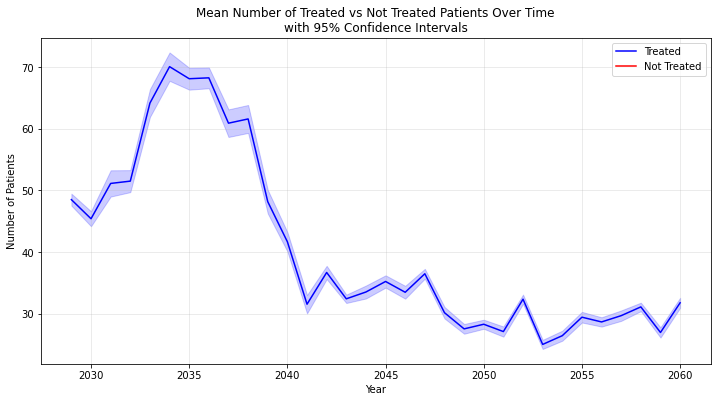

In [32]:
# Calculate treated/not treated per year across simulations
treated_by_year = detailed_results['treatment_timelines'].drop_duplicates(
    subset=['simulation_id', 'patient_uuid', 'treatment_year']
).groupby(['simulation_id', 'treatment_year', 'treated']).size().reset_index(name='count')

# Calculate mean and confidence intervals
stats_by_year = treated_by_year.groupby(['treatment_year', 'treated'])['count'].agg([
    'mean',
    'std'
]).reset_index()

# Calculate 95% CI
stats_by_year['ci_lower'] = stats_by_year['mean'] - 1.96 * stats_by_year['std'] / np.sqrt(N)
stats_by_year['ci_upper'] = stats_by_year['mean'] + 1.96 * stats_by_year['std'] / np.sqrt(N)

# Create plot
plt.figure(figsize=(12, 6))
for treated in [True, False]:
    data = stats_by_year[stats_by_year['treated'] == treated]
    label = 'Treated' if treated else 'Not Treated'
    color = 'blue' if treated else 'red'
    
    plt.plot(data['treatment_year'], data['mean'], label=label, color=color)
    plt.fill_between(data['treatment_year'], 
                     data['ci_lower'], 
                     data['ci_upper'],
                     alpha=0.2,
                     color=color)

plt.xlabel('Year')
plt.ylabel('Number of Patients')
plt.title('Mean Number of Treated vs Not Treated Patients Over Time\nwith 95% Confidence Intervals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
###############################################################################
# Treatment Analysis
###############################################################################

def analyze_treatment_patterns(detailed_results):
    """
    Analyze and visualize treatment patterns from simulation results
    """
    # Get treated patients data
    treated_df = detailed_results['treatment_timelines'][
        detailed_results['treatment_timelines']['treated'] == True
    ].copy()
    
    # Group by simulation_id to get statistics
    per_sim_stats = treated_df.groupby('simulation_id').agg({
        'patient_uuid': 'count'
    }).describe()
    
    print("\nPatients Treated per Simulation:")
    print(f"Mean: {per_sim_stats.loc['mean', 'patient_uuid']:.0f}")
    print(f"Std: {per_sim_stats.loc['std', 'patient_uuid']:.0f}")
    print(f"Min: {per_sim_stats.loc['min', 'patient_uuid']:.0f}")
    print(f"Max: {per_sim_stats.loc['max', 'patient_uuid']:.0f}")
    
    # Calculate average distribution across regions per simulation
    region_dist = treated_df.groupby(['simulation_id', 'region', 'iso3']).size().reset_index(name='treated_count')
    avg_region_dist = region_dist.groupby(['region', 'iso3'])['treated_count'].agg([
        'mean', 'std', 'min', 'max'
    ]).reset_index()
    
    avg_region_dist['percent'] = (avg_region_dist['mean'] / avg_region_dist['mean'].sum()) * 100
    
    # Create choropleth map using average values
    fig = go.Figure(data=go.Choropleth(
        locations=avg_region_dist['iso3'],
        z=avg_region_dist['mean'],
        text=avg_region_dist['region'],
        colorscale=['#F1ECE2', '#2F6CD6'],
        colorbar_title="Mean Treated",
        marker_line_color='white',
        marker_line_width=0.5,
        hovertemplate='<b>%{text}</b><br>Mean Treated: %{z}<br>Percent: %{customdata[0]:.1f}%<br>Std: %{customdata[1]:.1f}<extra></extra>',
        customdata=np.stack((avg_region_dist['percent'], avg_region_dist['std']), axis=-1)
    ))
    
    fig.update_layout(
        title_text='Average Geographic Distribution of Treated Patients per Simulation',
        geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
        template='plotly_white'
    )
    fig.write_image("./output/treatment_geography.png", scale=2)
    
    # Age analysis per simulation
    age_stats = treated_df.groupby(['simulation_id', 'region'])['age'].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).reset_index()
    
    avg_age_stats = age_stats.groupby('region').agg({
        'mean': ['mean', 'std'],
        'count': ['mean', 'std']
    }).round(1)
    
    # Create age distribution plot
    fig = go.Figure()
    for region in age_stats['region'].unique():
        region_data = age_stats[age_stats['region'] == region]
        fig.add_trace(go.Box(
            y=region_data['mean'],
            name=region,
            boxpoints='outliers',
            marker_color='#2F6CD6' if region == 'Americas' else '#FF7F0E'
        ))
    
    fig.update_layout(
        title='Age Distribution of Treated Patients by Region (Across Simulations)',
        yaxis_title='Mean Age',
        xaxis_title='Region',
        template='plotly_white'
    )
    fig.write_image("./output/age_at_treatment.png", scale=2)
    
    return {
        'per_simulation': per_sim_stats,
        'age_stats': avg_age_stats,
        'geographic_dist': avg_region_dist.nlargest(5, 'mean')
    }

# Print results with more detail
def print_treatment_summary(analysis_results):
    print("\nTreatment Analysis Summary:")
    print("-" * 50)
    
    print("\nAge Statistics by Region (Mean ± Std):")
    for region in analysis_results['age_stats'].index:
        mean_age = analysis_results['age_stats'].loc[region, ('mean', 'mean')]
        std_age = analysis_results['age_stats'].loc[region, ('mean', 'std')]
        mean_count = analysis_results['age_stats'].loc[region, ('count', 'mean')]
        std_count = analysis_results['age_stats'].loc[region, ('count', 'std')]
        print(f"\n{region}:")
        print(f"Age: {mean_age:.1f} ± {std_age:.1f}")
        print(f"Patients per simulation: {mean_count:.0f} ± {std_count:.0f}")
    
    print("\nTop 5 Countries by Average Treatment Count per Simulation:")
    top_5 = analysis_results['geographic_dist']
    for _, row in top_5.iterrows():
        print(f"{row['region']} ({row['iso3']}): {row['mean']:.0f} ± {row['std']:.0f} ({row['percent']:.1f}%)")

# Add after the existing analyze_treatment_patterns function

def plot_treatment_status_over_time(detailed_results):
    """
    Creates a stacked area plot showing treated vs untreated patients over time
    with 95% confidence intervals
    """
    # Get the timeline data
    df = detailed_results['treatment_timelines']
    
    # Calculate yearly totals by simulation
    yearly_stats = []
    for year in sorted(df['year'].unique()):
        year_data = df[df['year'] == year]
        
        # For each simulation, calculate treated and untreated counts
        sim_stats = []
        for sim_id in df['simulation_id'].unique():
            sim_data = year_data[year_data['simulation_id'] == sim_id]
            treated = sim_data['treated'].sum()
            untreated = len(sim_data) - treated
            sim_stats.append({
                'year': year,
                'simulation_id': sim_id,
                'treated': treated,
                'untreated': untreated
            })
        
        # Calculate statistics across simulations
        sim_df = pd.DataFrame(sim_stats)
        stats = {
            'year': year,
            'treated_mean': sim_df['treated'].mean(),
            'treated_ci_low': np.percentile(sim_df['treated'], 2.5),
            'treated_ci_high': np.percentile(sim_df['treated'], 97.5),
            'untreated_mean': sim_df['untreated'].mean(),
            'untreated_ci_low': np.percentile(sim_df['untreated'], 2.5),
            'untreated_ci_high': np.percentile(sim_df['untreated'], 97.5)
        }
        yearly_stats.append(stats)
    
    # Create the figure
    fig = go.Figure()
    
    # Add untreated patients area with CI
    years = [stat['year'] for stat in yearly_stats]
    
    # Add untreated CI area
    fig.add_trace(go.Scatter(
        x=years + years[::-1],
        y=[stat['untreated_ci_high'] for stat in yearly_stats] + 
          [stat['untreated_ci_low'] for stat in yearly_stats][::-1],
        fill='toself',
        fillcolor='rgba(243, 168, 123, 0.2)',  # Light orange
        line=dict(width=0),
        showlegend=False,
        name='Untreated CI'
    ))
    
    # Add untreated mean line
    fig.add_trace(go.Scatter(
        x=years,
        y=[stat['untreated_mean'] for stat in yearly_stats],
        line=dict(color='#F3A87B', width=2),  # Orange
        name='Untreated Patients'
    ))
    
    # Add treated CI area
    fig.add_trace(go.Scatter(
        x=years + years[::-1],
        y=[stat['treated_ci_high'] for stat in yearly_stats] + 
          [stat['treated_ci_low'] for stat in yearly_stats][::-1],
        fill='toself',
        fillcolor='rgba(47, 108, 214, 0.2)',  # Light blue
        line=dict(width=0),
        showlegend=False,
        name='Treated CI'
    ))
    
    # Add treated mean line
    fig.add_trace(go.Scatter(
        x=years,
        y=[stat['treated_mean'] for stat in yearly_stats],
        line=dict(color='#2F6CD6', width=2),  # Blue
        name='Treated Patients'
    ))
    
    # Update layout
    fig.update_layout(
        title='Patient Treatment Status Over Time',
        xaxis_title='Year',
        yaxis_title='Number of Patients',
        template='plotly_white',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        width=1000,
        height=600,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )
    
    # Save the figure
    fig.write_image("./output/treatment_status_over_time.png", scale=2)
    
    return fig

# Add this line where you're running the other analyses
treatment_status_fig = plot_treatment_status_over_time(detailed_results)

###############################################################################
# Financial Analysis
###############################################################################

def analyze_financial_metrics(detailed_results, simuleringsparametre):
    """
    Analyze NPV and ROI across clinical phases using expected NPV approach
    """
    sim_df = pd.DataFrame(detailed_results['simulations'])
    phase_df = pd.DataFrame(detailed_results['phases'])
    
    # Merge simulation details with phase details
    phase_df = phase_df.merge(
        sim_df[['simulation_id', 'total_revenue', 'total_duration', 'success']], 
        on='simulation_id'
    )
    
    # Define phases with their respective cost, duration, and success columns
    phases = [
        {'name': 'preclinical', 'cost_col': 'preclinical_cost', 'duration_col': 'preclinical_duration', 'success_col': 'preclinical_success'},
        {'name': 'phase12', 'cost_col': 'phase12_cost', 'duration_col': 'phase12_duration', 'success_col': 'phase12_success'},
        {'name': 'phase3', 'cost_col': 'phase3_cost', 'duration_col': 'phase3_duration', 'success_col': 'phase3_success'},
        {'name': 'approval', 'cost_col': 'approval_cost', 'duration_col': 'approval_duration', 'success_col': 'approval_success'}
    ]
    
    # Define discount rate
    discount_rate = simuleringsparametre['diskonteringsrente']
    
    # Initialize dictionaries to store NPV and ROI results
    npv_results = {phase['name']: [] for phase in phases}
    roi_results = {'approval': []}  # Only approval phase will have ROI
    
    # Iterate over each simulation to calculate per-phase NPV and ROI
    for idx, row in phase_df.iterrows():
        cumulative_success = True
        cumulative_cost = 0
        cumulative_duration = 0
        cumulative_npv = 0
        phase_npv = {}
        
        for phase in phases:
            phase_name = phase['name']
            cost = row[phase['cost_col']]
            duration = row[phase['duration_col']]
            success = row[phase['success_col']]
            
            # Update cumulative cost and duration
            cumulative_cost += cost
            cumulative_duration += duration
            
            # Discount the cost
            pv_cost = -cost / (1 + discount_rate) ** cumulative_duration
            cumulative_npv += pv_cost
            
            # Store NPV for this phase
            phase_npv[phase_name] = pv_cost
            npv_results[phase_name].append(pv_cost)
            
            # Check for success up to the current phase
            if not success:
                cumulative_success = False
                break  # Exit early since the project failed
            
            # If at approval phase and successful, calculate discounted revenue
            if phase_name == 'approval' and cumulative_success:
                revenue = row['total_revenue']
                pv_revenue = revenue / (1 + discount_rate) ** cumulative_duration
                cumulative_npv += pv_revenue
                
                # Update NPV for approval phase
                phase_npv[phase_name] += pv_revenue
                npv_results[phase_name][idx] = phase_npv[phase_name]
                
                # Calculate ROI for approval
                roi = (revenue - cumulative_cost) / cumulative_cost if cumulative_cost > 0 else np.nan
                roi_results['approval'].append(roi)
        
        # Handle cases where approval wasn't reached
        if not cumulative_success:
            # Append NaN for ROI if approval wasn't successful
            roi_results['approval'].append(np.nan)
            # For remaining phases, append NaN to ensure consistency
            for phase in phases:
                phase_name = phase['name']
                if len(npv_results[phase_name]) < idx + 1:
                    npv_results[phase_name].append(np.nan)
    
    # Convert NPV and ROI results to DataFrames for statistical analysis
    npv_df = pd.DataFrame(npv_results)
    roi_df = pd.DataFrame(roi_results)
    
    # Calculate statistics for NPV
    npv_stats = {}
    for phase in phases:
        phase_name = phase['name']
        phase_npv = npv_df[phase_name].dropna()
        if not phase_npv.empty:
            npv_mean = phase_npv.mean()
            npv_std = phase_npv.std()
            ci_low, ci_high = np.percentile(phase_npv, [2.5, 97.5])
            success_rate = phase_df[phase['success_col']].mean()
            
            npv_stats[phase_name] = {
                'mean': npv_mean,
                'std': npv_std,
                'ci_low': ci_low,
                'ci_high': ci_high,
                'success_rate': success_rate
            }
        else:
            npv_stats[phase_name] = {
                'mean': np.nan,
                'std': np.nan,
                'ci_low': np.nan,
                'ci_high': np.nan,
                'success_rate': phase_df[phase['success_col']].mean()
            }
    
    # Calculate statistics for ROI (only approval phase)
    roi_stats = {}
    phase_name = 'approval'
    phase_roi = roi_df[phase_name].dropna()
    if not phase_roi.empty:
        roi_mean = phase_roi.mean()
        roi_std = phase_roi.std()
        success_rate = phase_df[phases[-1]['success_col']].mean()
        
        roi_stats[phase_name] = {
            'roi_mean': roi_mean,
            'roi_std': roi_std,
            'success_rate': success_rate
        }
    else:
        roi_stats[phase_name] = {
            'roi_mean': np.nan,
            'roi_std': np.nan,
            'success_rate': phase_df[phases[-1]['success_col']].mean()
        }
    
    # Create NPV visualization
    phases_plot = [phase['name'] for phase in phases]
    npv_means = [npv_stats[p]['mean'] for p in phases_plot]
    npv_ci_low = [npv_stats[p]['ci_low'] for p in phases_plot]
    npv_ci_high = [npv_stats[p]['ci_high'] for p in phases_plot]
    
    fig = go.Figure()
    
    # Add mean NPV bars
    fig.add_trace(go.Bar(
        x=phases_plot,
        y=npv_means,
        name='Mean NPV',
        marker_color='#2F6CD6'
    ))
    
    # Add confidence interval as error bars
    fig.add_trace(go.Scatter(
        x=phases_plot,
        y=npv_ci_high,
        mode='lines',
        line=dict(color='rgba(255,255,255,0)'),
        showlegend=False,
        hoverinfo='none'
    ))
    
    fig.add_trace(go.Scatter(
        x=phases_plot,
        y=npv_ci_low,
        mode='lines',
        fill='tonexty',
        fillcolor='rgba(47, 108, 214, 0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='95% CI'
    ))
    
    fig.update_layout(
        title='Per-Phase NPV (with 95% CI)',
        xaxis_title='Clinical Phase',
        yaxis_title='NPV (EUR)',
        template='plotly_white',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    
    fig.write_image("./output/npv_by_phase.png", scale=2)
    
    # Create ROI visualization (only for approval phase)
    approval_phase = 'approval'
    if not np.isnan(roi_stats[approval_phase]['roi_mean']):
        roi_mean = roi_stats[approval_phase]['roi_mean']
        roi_std = roi_stats[approval_phase]['roi_std']
        success_rate = roi_stats[approval_phase]['success_rate'] * 100
        
        fig = go.Figure()
        
        # Add ROI bar
        fig.add_trace(go.Bar(
            x=[approval_phase.capitalize()],
            y=[roi_mean],
            name='Mean ROI',
            marker_color='#2F6CD6',
            error_y=dict(
                type='data',
                array=[roi_std],
                visible=True
            )
        ))
        
        # Add success rate as a separate y-axis
        fig.add_trace(go.Scatter(
            x=[approval_phase.capitalize()],
            y=[success_rate],
            name='Success Rate (%)',
            yaxis='y2',
            mode='markers+lines',
            line=dict(color='#F3A87B', width=2),
            marker=dict(size=10)
        ))
        
        fig.update_layout(
            title='ROI and Success Rate at Approval Phase',
            xaxis_title='Clinical Phase',
            yaxis=dict(
                title='Mean ROI',
                titlefont=dict(color='#2F6CD6'),
                tickfont=dict(color='#2F6CD6')
            ),
            yaxis2=dict(
                title='Success Rate (%)',
                titlefont=dict(color='#F3A87B'),
                tickfont=dict(color='#F3A87B'),
                overlaying='y',
                side='right',
                range=[0, 100]
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
                x=0.99
            ),
            template='plotly_white',
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)'
        )
        
        fig.write_image("./output/roi_by_phase.png", scale=2)
    else:
        print("\nROI at Approval Phase could not be calculated due to insufficient successful simulations.")
    
    return npv_stats, roi_stats

# Print financial summary
def print_financial_summary(npv_stats, roi_stats):
    print("\nFinancial Analysis Summary:")
    print("-" * 50)
    
    print("\nNPV Results by Phase:")
    for phase, results in npv_stats.items():
        print(f"\n{phase.capitalize()}:")
        if not np.isnan(results['mean']):
            print(f"Mean NPV: €{results['mean']/1e6:.1f}M")
            print(f"95% CI: [€{results['ci_low']/1e6:.1f}M, €{results['ci_high']/1e6:.1f}M]")
            print(f"Success Rate: {results['success_rate']*100:.1f}%")
        else:
            print("No valid NPV data available.")
    
    print("\nROI Analysis by Phase:")
    print("-" * 50)
    for phase, results in roi_stats.items():
        if phase == 'approval':
            if not np.isnan(results['roi_mean']):
                print(f"\n{phase.capitalize()}:")
                print(f"Mean ROI: {results['roi_mean']:.2f}")
                print(f"Std ROI: {results['roi_std']:.2f}")
                print(f"Success Rate: {results['success_rate']*100:.1f}%")
            else:
                print(f"\n{phase.capitalize()}:")
                print("ROI could not be calculated due to insufficient successful simulations.")
        else:
            print(f"\n{phase.capitalize()}:")
            print("ROI not calculated for this phase.")

# Run the analyses with detailed_results
analysis_results = analyze_treatment_patterns(detailed_results)
print_treatment_summary(analysis_results)

npv_stats, roi_stats = analyze_financial_metrics(detailed_results, simuleringparametre)
print_financial_summary(npv_stats, roi_stats)

# Print summary statistics
print("\nTreatment Analysis Summary:")
print("-" * 50)
print("\nAge Statistics by Region:")
print(analysis_results['age_stats'])
print("\nTop 5 Countries by Treatment Count:")
print(analysis_results['geographic_dist'])

print("\nFinancial Analysis Summary:")
print("-" * 50)
print("\nNPV Results by Phase (in millions EUR):")
for phase, results in npv_stats.items():
    print(f"\n{phase.capitalize()}:")
    if not np.isnan(results['mean']):
        print(f"Mean: {results['mean']/1e6:.1f}M")
        print(f"95% CI: [{results['ci_low']/1e6:.1f}M, {results['ci_high']/1e6:.1f}M]")
    else:
        print("No valid NPV data available.")

print("\nROI Analysis by Phase:")
print("-" * 50)
for phase, results in roi_stats.items():
    if phase == 'approval':
        if not np.isnan(results['roi_mean']):
            print(f"\n{phase.capitalize()}:")
            print(f"Mean ROI: {results['roi_mean']:.2f}")
            print(f"Std ROI: {results['roi_std']:.2f}")
            print(f"Success Rate: {results['success_rate']*100:.1f}%")
        else:
            print(f"\n{phase.capitalize()}:")
            print("ROI could not be calculated due to insufficient successful simulations.")
    else:
        print(f"\n{phase.capitalize()}:")
        print("ROI not calculated for this phase.")


Patients Treated per Simulation:
Mean: 25669
Std: 1482
Min: 22448
Max: 29194

Treatment Analysis Summary:
--------------------------------------------------

Age Statistics by Region (Mean ± Std):

Americas:
Age: 13.8 ± 0.4
Patients per simulation: 14218 ± 850

Asia:
Age: 11.8 ± 0.8
Patients per simulation: 958 ± 155

Europe:
Age: 13.3 ± 0.4
Patients per simulation: 10493 ± 618

Top 5 Countries by Average Treatment Count per Simulation:
Americas (USA): 13036 ± 781 (50.7%)
Europe (DEU): 2430 ± 163 (9.4%)
Europe (FRA): 2315 ± 124 (9.0%)
Europe (ITA): 1406 ± 101 (5.5%)
Americas (CAN): 1182 ± 86 (4.6%)

Financial Analysis Summary:
--------------------------------------------------

NPV Results by Phase:

Preclinical:
Mean NPV: €-0.0M
95% CI: [€-0.0M, €-0.0M]
Success Rate: 84.0%

Phase12:
Mean NPV: €-2.2M
95% CI: [€-3.1M, €-1.4M]
Success Rate: 83.3%

Phase3:
Mean NPV: €-5.1M
95% CI: [€-7.5M, €-3.1M]
Success Rate: 72.9%

Approval:
Mean NPV: €683.3M
95% CI: [€-0.8M, €1124.2M]
Success Rate: 9

# Figures for pitch

In [11]:
# Create a custom color scale using your colors
custom_colors = [
    '#F1ECE2',  # Ivory
    '#2F6CD6',  # Ultramarine Blue
]

alive_2023 = timeline.loc[
    (timeline.alive == True) & 
    (timeline.year == 2023)
].merge(
    befolkning[['ISO2 Alpha-code', 'ISO3 Alpha-code']].drop_duplicates(),
    left_on='country',
    right_on='ISO2 Alpha-code'
)

alive_2023 = alive_2023.groupby('ISO3 Alpha-code').size().reset_index(name='count')

# Create a copy with capped values
alive_2023_capped = alive_2023.copy()
alive_2023_capped['count_capped'] = alive_2023_capped['count'].clip(upper=100)

fig = px.choropleth(
    alive_2023_capped,
    locations='ISO3 Alpha-code',
    locationmode='ISO-3',
    color='count_capped',
    hover_data=['count'],
    hover_name='ISO3 Alpha-code',
    color_continuous_scale=custom_colors,
    title='Number of Living Patients per Country in 2023 (Values capped at 100+)',
    range_color=[0, 100]
)

fig.update_layout(
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=True, projection_type='equirectangular'),
    width=1000,
    height=600,
    coloraxis_colorbar_title="Patients",
    # Update colorbar ticks to show 100+
    coloraxis_colorbar=dict(
        ticktext=['0', '25', '50', '75', '100+'],
        tickvals=[0, 25, 50, 75, 100],
    )
)

# Update hover template to show both capped and original values
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>' +
                  'Patients: %{customdata[0]}<br>' +
                  '<extra></extra>'
)



fig.show()

# Update layout to include transparent background
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    plot_bgcolor='rgba(0,0,0,0)',   # Transparent plot area
    title_x=0.5,
    geo=dict(
        showframe=False, 
        showcoastlines=True, 
        projection_type='equirectangular',
        bgcolor='rgba(0,0,0,0)'  # Transparent map background
    ),
    width=1000,
    height=600
)

# Save the figure with transparent background
fig.write_image("./output/world_map_patients_2023.png", scale=2, format="png")

In [12]:
# Calculate regional totals for 2023
north_america_total = timeline.loc[
    (timeline.alive == True) & 
    (timeline.year == 2023) & 
    (timeline.country.isin(['US', 'CA']))
].alive.count()

europe_total = timeline.loc[
    (timeline.alive == True) & 
    (timeline.year == 2023) & 
    (timeline.region == 'Europe')
].alive.count()

asia_total = timeline.loc[
    (timeline.alive == True) & 
    (timeline.year == 2023) & 
    (timeline.region == 'Asia')
].alive.count()

In [14]:
fig_data = timeline.loc[(timeline.alive == True)
             &(timeline.region.isin(["Americas","Europe"]))
             &(timeline.year <2024)].groupby("year").alive.count()

In [9]:
import plotly.graph_objects as go

# Data
diseases = ['Lowe syndrome / DD2', 'Cystinosis', 'Fabry Disease']
patients = [8500, 50000, 250000]

# Format numbers with commas
formatted_patients = [f"{p:,}" for p in patients]

# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Pipeline",
    orientation="v",
    measure=["relative"] * len(diseases),
    x=diseases,
    y=patients,
    connector={"line": {"color": "rgb(63, 63, 63)"}},
    increasing={"marker": {"color": "#2F6CD6"}},
    text=formatted_patients,
    textposition="outside",
    textfont={"size": 20}
))

# Update layout with margin and height adjustments
fig.update_layout(
    showlegend=False,
    yaxis={
        'showticklabels': False,
        'showgrid': False,
        'zeroline': False,
        'range': [3.5, 5.7]  # Adjust log scale range to show full label
    },
    yaxis_type="log",
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=800,
    height=600,
    margin=dict(t=100)  # Add top margin to accommodate label
)

# Show the figure
fig.show()

# Save the figure
fig.write_image("./output/disease_prevalence_waterfall.png", scale=2, format="png")

In [41]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Refined color scheme based on Ultramarine and Orange
custom_colors = [
    '#2F6CD6',  # Ultramarine Blue
    '#F3A87B',  # Orange Shake
    '#2EB873',  # Emerald Green
    '#8C4D9D',  # Royal Purple
]

# Create the data with processed ranges (excluding Luxembourg)
data = {
    'Country': [
        'Germany', 'France', 'Italy', 'Belgium', 'Austria', 'Switzerland',
        'GB-England', 'GB-Scotland', 'Denmark', 'Sweden', 'Finland', 'Iceland',
        'Spain', 'Greece', 'Portugal', 'Cyprus', 'Malta', 'Slovenia',
        'Czech Republic', 'Poland', 'Slovakia', 'Hungary', 'Romania', 'Bulgaria',
        'Turkey', 'Estonia', 'Latvia', 'Lithuania', 'Albania', 'North Macedonia',
        'Serbia', 'Bosnia & Herzegovina'
    ],
    'Region': [
        'Western', 'Western', 'Western', 'Western', 'Western', 'Western',
        'Northern', 'Northern', 'Northern', 'Northern', 'Northern', 'Northern',
        'Southern', 'Southern', 'Southern', 'Southern', 'Southern', 'Eastern',
        'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern',
        'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern', 'Eastern',
        'Eastern', 'Eastern'
    ],
    'GDP': [  # Converting to EUR (approximate conversion rate of 0.92)
        57.5, 52.9, 43.7, 52.9, 57.5, 75.9,
        48.3, 48.3, 64.4, 57.5, 52.9, 66.7,
        36.8, 32.2, 35.0, 48.3, 48.3, 43.7,
        43.7, 39.1, 34.5, 34.5, 29.9, 27.6,
        34.5, 36.8, 36.8, 36.8, 18.4, 18.4,
        20.7, 16.1
    ],
    'Reimbursement': [
        87.5, 72.5, 72.5, 57.5, 52.5, 50,
        75, 55, 57.5, 52.5, 45, 2.5,
        35, 37.5, 40, 6, 4, 15,
        14, 11, 11, 9.5, 9, 4,
        6, 6, 6, 6, 0, 0,
        0, 0
    ]
}

df = pd.DataFrame(data)

# Calculate polynomial fit (2nd degree)
z = np.polyfit(df['GDP'], df['Reimbursement'], 1)
p = np.poly1d(z)

# Create figure
fig = go.Figure()

# Add scatter points for each region with custom colors
for i, region in enumerate(df['Region'].unique()):
    mask = df['Region'] == region
    fig.add_trace(go.Scatter(
        x=df[mask]['GDP'],
        y=df[mask]['Reimbursement'],
        mode='markers',
        name=region,
        marker=dict(color=custom_colors[i], size=10),
        text=df[mask]['Country'],
        hovertemplate="<b>%{text}</b><br>" +
                     "GDP: €%{x:.1f}k<br>" +
                     "Reimbursement: %{y:.1f}%<br>" +
                     "<extra></extra>"
    ))

# Add polynomial trendline
x_range = np.linspace(df['GDP'].min(), df['GDP'].max(), 100)
fig.add_trace(go.Scatter(
    x=x_range,
    y=p(x_range),
    mode='lines',
    line=dict(color='#262626', width=1),  # Using Ultramarine Blue for trendline
    name='Trend',
    showlegend=False
))

# Update layout
fig.update_layout(
    xaxis_title='Real GDP/Capita, PPP (k EUR, 2022)',
    yaxis_title='Share Reimbursed (%)',
    width=800,
    height=400,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    showlegend=True,
    legend_title_text="European Region"
)

# Show the plot
fig.show()

# Save the figure
fig.write_image("./output/reimbursement_gdp_scatter.png", scale=2, format="png")

In [16]:
import plotly.graph_objects as go
import pandas as pd

# Create the data
data = {
    'Year': [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032],
    'Incident': [294, 681, 3265, 8755, 15790, 22054, 27332, 31625, 34703, 37063],
    'Prevalent': [899, 3411, 10628, 16932, 19323, 19559, 18588, 16998, 14697, 12730]
}

df = pd.DataFrame(data)

# Create the stacked bar chart
fig = go.Figure()

# Add Incident cases bar
fig.add_trace(go.Bar(
    x=df['Year'],
    y=df['Incident'],
    name='Incident',
    marker_color='#2F6CD6'  # Ultramarine Blue
))

# Add Prevalent cases bar
fig.add_trace(go.Bar(
    x=df['Year'],
    y=df['Prevalent'],
    name='Prevalent',
    marker_color='#8DAEE6'  # Orange Shake
))

# Update layout with all settings including axes
fig.update_layout(
    barmode='stack',
    xaxis_title='Year',
    yaxis_title='Number of Patients',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=800,
    height=400,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    # Add axis settings directly in update_layout
    xaxis=dict(
        tickmode='linear',
        dtick=1,
        gridcolor='#E5E5E5'
    ),
    yaxis=dict(
        gridcolor='#E5E5E5',
        zeroline=True,
        zerolinecolor='#E5E5E5'
    )
)

# Show the figure
fig.show()

# Save the figure
fig.write_image("./output/patient_forecast.png", scale=2, format="png")

In [39]:
start_value = 1193
end_value = 49793
years = 9

cagr = (end_value/start_value)**(1/years) - 1
print(f"CAGR 2023-2032: {cagr:.1%}")

CAGR 2023-2032: 51.4%


In [36]:
import plotly.graph_objects as go
import pandas as pd

# Create the data
data = {
    'Year': list(range(2020, 2031)),
    'Mean': [1, 5, 8, 12, 20, 25, 30, 35, 40, 45, 50],
    'Min': [0, 2, 5, 8, 15, 20, 25, 30, 35, 35, 35],
    'Max': [2, 10, 15, 20, 30, 35, 40, 45, 50, 55, 60]
}

df = pd.DataFrame(data)

# Create the figure
fig = go.Figure()

# Add the range area
fig.add_trace(go.Scatter(
    x=df['Year'].tolist() + df['Year'].tolist()[::-1],
    y=df['Max'].tolist() + df['Min'].tolist()[::-1],
    fill='toself',
    fillcolor='rgba(47, 108, 214, 0.2)',  # Ultramarine Blue with transparency
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='Range'
))

# Add the mean line
fig.add_trace(go.Scatter(
    x=df['Year'],
    y=df['Mean'],
    mode='lines+markers',
    line=dict(color='#2F6CD6', width=2),  # Ultramarine Blue
    marker=dict(size=8),
    name='Mean'
))

# Update layout
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Cumulative Launches',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=800,
    height=400,
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    xaxis=dict(
        tickmode='linear',
        dtick=1,
        gridcolor='#E5E5E5'
    ),
    yaxis=dict(
        gridcolor='#E5E5E5',
        zeroline=True,
        zerolinecolor='#E5E5E5',
        range=[0, 65]  # Set y-axis range to accommodate the maximum value
    )
)

# Show the figure
fig.show()

# Save the figure
fig.write_image("./output/cumulative_launches_forecast.png", scale=2, format="png")

In [14]:
gene_therapies = [
    {
        "therapy": "Libmeldy",
        "indication": "Metachromatic Leukodystrophy (MLD)",
        "price_usd_millions": 4.3,
        "prevalence": "~1 in 40,000–160,000 births"
    },
    {
        "therapy": "Hemgenix",
        "indication": "Hemophilia B",
        "price_usd_millions": 3.5,
        "prevalence": "~1 in 25,000 male births"
    },
    {
        "therapy": "Elevidys",
        "indication": "Duchenne Muscular Dystrophy (DMD)",
        "price_usd_millions": 3.2,
        "prevalence": "~1 in 3,500–5,000 male births"
    },
    {
        "therapy": "Skysona",
        "indication": "Cerebral Adrenoleukodystrophy (CALD)",
        "price_usd_millions": 3.0,
        "prevalence": "~1 in 15,000–20,000 male births"
    },
    {
        "therapy": "Roctavian",
        "indication": "Hemophilia A",
        "price_usd_millions": 2.9,
        "prevalence": "~1 in 5,000 male births"
    }
]

gene_therapies.append({
    "therapy": "Kebilidi",
    "indication": "",  # Left blank as not provided
    "price_usd_millions": 3.8,
    "prevalence": "1 in 1,000,000"
})


In [18]:
import plotly.graph_objects as go
import re

# Function to extract the rarest prevalence and convert to overall population
def get_rarest_prevalence(prev_str):
    # Extract numbers using regex
    numbers = re.findall(r'1 in ([\d,]+)(?:–|\-)?([\d,]+)?', prev_str)[0]
    # Convert to integers, removing commas
    numbers = [int(n.replace(',','')) for n in numbers if n]
    # Get the largest number (rarest occurrence)
    rarest = max(numbers)
    
    # If prevalence is for males only, multiply by 2 for overall population
    if 'male' in prev_str.lower():
        rarest *= 2
        
    return rarest

# Process the data
processed_data = []
for therapy in gene_therapies:
    processed_data.append({
        'therapy': therapy['therapy'],
        'price': therapy['price_usd_millions'],
        'prevalence': get_rarest_prevalence(therapy['prevalence']),
        'indication': therapy['indication']
    })

# Sort by price
processed_data.sort(key=lambda x: x['price'])

# Create the bar chart
fig = go.Figure()

# Add bars
fig.add_trace(go.Bar(
    x=[d['therapy'] for d in processed_data],
    y=[d['price'] for d in processed_data],
    text=[f"${d['price']}M<br>1:{d['prevalence']:,}" for d in processed_data],
    textposition='outside',
    marker_color='#2F6CD6',  # Ultramarine Blue
    hovertemplate="<b>%{x}</b><br>" +
                  "Price: $%{y}M<br>" +
                  "<extra></extra>"
))

# Update layout
fig.update_layout(
    yaxis_title='Price (USD Millions)',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=800,
    height=400,
    showlegend=False,
    xaxis=dict(
        tickangle=45,
        gridcolor='#E5E5E5'
    ),
    yaxis=dict(
        gridcolor='#E5E5E5',
        zeroline=True,
        zerolinecolor='#E5E5E5',
        range=[0, max([d['price'] for d in processed_data]) * 1.2]  # Add 20% padding
    )
)

# Show the figure
fig.show()

# Save the figure
fig.write_image("./output/gene_therapy_prices.png", scale=2, format="png")

In [1]:
import plotly.graph_objects as go

# Data
labels = ['R&D', 'Business Development', 'Administration']
values = [60, 20,20]
colors = ['#2F6CD6', '#8DAEE6', '#F3A87B', '#F1ECE2']

# Create pie chart
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.4,
    marker_colors=colors
)])

# Update layout
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=800,
    height=500,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    )
)

# Show the figure
fig.show()

# Save the figure
fig.write_image("use_of_funds_pie.png", scale=2)

Yearly donations (DKK):
2025: 758,086
2026: 1,364,555
2027: 2,456,199
2028: 4,421,159

Total: 9,000,000


In [5]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime

# Read the CSV file
df = pd.read_csv('/Users/smeden/Desktop/Lowe Syndrome Collaborative/Walther Therapeutics/git/Models/Finansiel model/DanskeDirekteForen-13834067-20250205.csv')

# Convert date column and calculate daily statistics
df['Date'] = pd.to_datetime(df['Date'])
daily_amounts = df.groupby('Date')['Amount'].sum()

# Calculate monthly averages
monthly_stats = df.groupby(df['Date'].dt.strftime('%Y-%m'))['Amount'].agg(['mean', 'sum', 'count'])

print("\nMonthly Statistics:")
print(monthly_stats)

# Create visualization of daily amounts
fig = go.Figure()

# Add daily amounts scatter plot
fig.add_trace(go.Scatter(
    x=daily_amounts.index,
    y=daily_amounts.values,
    mode='lines+markers',
    name='Daily Amounts',
    marker_color='#2F6CD6',
    line_color='#2F6CD6'
))

# Add monthly average line
monthly_avg = df.groupby(df['Date'].dt.strftime('%Y-%m'))['Amount'].mean()
fig.add_trace(go.Scatter(
    x=monthly_avg.index,
    y=monthly_avg.values,
    mode='lines',
    name='Monthly Average',
    line=dict(color='#F3A87B', width=2)
))

# Update layout
fig.update_layout(
    title="Daily Donations and Monthly Averages",
    xaxis_title='Date',
    yaxis_title='Amount (DKK)',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000,
    height=500,
    showlegend=True
)

# Show the figure
fig.show()

# Save the figure
fig.write_image("./output/actual_donations_analysis.png", scale=2, format="png")

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average daily donation: {daily_amounts.mean():.2f} DKK")
print(f"Median daily donation: {daily_amounts.median():.2f} DKK")
print(f"Maximum daily donation: {daily_amounts.max():.2f} DKK")
print(f"Minimum daily donation: {daily_amounts.min():.2f} DKK")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xf8 in position 19: invalid start byte